In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
from scipy.stats.stats import pearsonr
import copy
import matplotlib.pyplot as plt

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

NET_PATH = os.path.join(PATH_PREFIX, 'models/lenet/saves/lenet_relu.save')
SAVE_DATA = os.path.join(PATH_PREFIX, 'results/test_share.csv')

FOCUS_SEARCH_SPACE = np.arange(0, 10, 0.2)
SPREAD_SEARCH_SPACE = np.arange(0, 10, 0.2)

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, 'relu')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

In [6]:
LAYER = 1
SHARE_CLUSTERS = [5, 5, 5, 5, 5]

In [7]:
w_delta = []
acc = []
cluster_num_delta = []

org_weight = copy.deepcopy(torch.flatten(ws_controller.model_layers[LAYER].weight.cpu()).detach().numpy())
num_in_cluster_mean = len(org_weight) / SHARE_CLUSTERS[LAYER]

for focus_val in FOCUS_SEARCH_SPACE:
    reset_w = torch.tensor(copy.deepcopy(org_weight)).to(DEVICE).reshape(ws_controller.model_layers[LAYER].weight.shape)
    ws_controller.model_layers[LAYER].weight.data = reset_w
    ws_controller.model_layers[LAYER].virt_weight_params = reset_w.numel()
    ws_controller.reset()
    
    acc.append(ws_controller.share(SHARE_CLUSTERS, [LAYER], mods_focus=[focus_val for _ in range(5)], mods_spread=[2, 2, 2, 2, 2])['accuracy'])

    post_share_weights = torch.flatten(ws_controller.model_layers[LAYER].weight.cpu()).detach().numpy()
    w_delta.append(np.sum(np.abs(post_share_weights - org_weight)))

    cluster_num_delta.append(np.sum(np.abs(num_in_cluster_mean - np.unique(post_share_weights, return_counts=True)[1])))

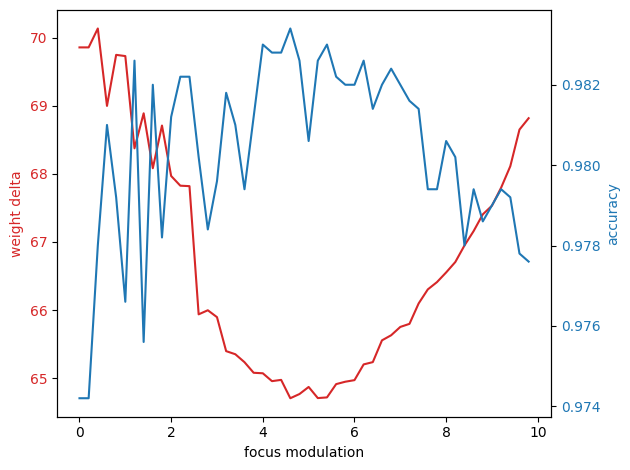

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('focus modulation')
ax1.set_ylabel('weight delta', color=color)
ax1.plot(FOCUS_SEARCH_SPACE, w_delta, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(FOCUS_SEARCH_SPACE, acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
pearsonr(w_delta, acc)

(-0.717696248917686, 4.479106745341961e-09)

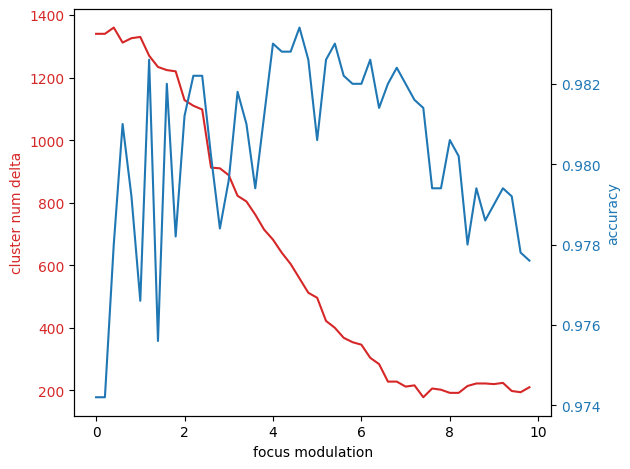

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('focus modulation')
ax1.set_ylabel('cluster num delta', color=color)
ax1.plot(FOCUS_SEARCH_SPACE, cluster_num_delta, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(FOCUS_SEARCH_SPACE, acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [11]:
pearsonr(cluster_num_delta, acc)

(-0.2946132426727158, 0.03781239061560301)

In [12]:
best_focus = FOCUS_SEARCH_SPACE[np.argmax(acc)]
org_weight = copy.deepcopy(torch.flatten(ws_controller.model_layers[LAYER].weight.cpu()).detach().numpy())

w_delta = []
acc = []

for spread_val in np.arange(0, 10, 0.2):
    reset_w = torch.tensor(copy.deepcopy(org_weight)).to(DEVICE).reshape(ws_controller.model_layers[LAYER].weight.shape)
    ws_controller.model_layers[LAYER].weight.data = reset_w
    ws_controller.model_layers[LAYER].virt_weight_params = reset_w.numel()
    ws_controller.reset()
    acc.append(ws_controller.share([5, 5, 5, 5, 5], [LAYER], mods_focus=[best_focus for _ in range(5)], mods_spread=[spread_val for _ in range(5)])['accuracy'])
    w_delta.append(np.sum(np.abs(torch.flatten(ws_controller.model_layers[LAYER].weight.cpu()).detach().numpy() - org_weight)))

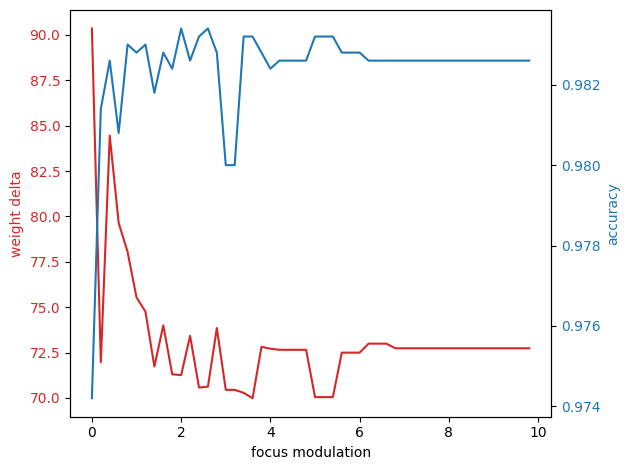

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('focus modulation')
ax1.set_ylabel('weight delta', color=color)
ax1.plot(SPREAD_SEARCH_SPACE, w_delta, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(SPREAD_SEARCH_SPACE, acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [14]:
pearsonr(w_delta, acc)

(-0.646781964246146, 3.8835802453809763e-07)